#Downloading libraries

In [2]:
# !pip install textblob
# !pip install vaderSentiment
# !pip install afinn
# !pip install geopandas
# !pip install catboost

#Loading Data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import re
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import mark_negation
from nltk.stem import WordNetLemmatizer
from afinn import Afinn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

##Importing necessary libraries

##Loading the dataset

In [4]:
df = pd.read_csv('/content/Metaverse_tweets1.csv')

In [5]:
df.shape

(50003, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50003 entries, 0 to 50002
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_name         50002 non-null  object 
 1   user_location     16986 non-null  object 
 2   user_description  37112 non-null  object 
 3   user_created      50000 non-null  object 
 4   user_followers    50000 non-null  float64
 5   user_friends      50000 non-null  object 
 6   user_favourites   50000 non-null  object 
 7   user_verified     50000 non-null  object 
 8   date              49998 non-null  object 
 9   text              50000 non-null  object 
 10  hashtags          28671 non-null  object 
 11  source            49997 non-null  object 
 12  is_retweet        49997 non-null  object 
dtypes: float64(1), object(12)
memory usage: 5.0+ MB


In [7]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,Sukatna,NaN,NaN,2021-09-24 06:53:09+00:00,2.0,116,94,False,2021-11-15 08:24:11+00:00,@Haris51659768 @KnightMonter11 I think in the ...,NaN,Twitter for Android,False
1,Onur Rhein 🔺,Wann Deutschland?,"Sular yükseldiğinde balıklar karıncaları yer, ...",2020-03-31 21:12:16+00:00,126.0,1401,40101,False,2021-11-15 08:24:10+00:00,@ernealist This is the new metaverse game proj...,"['PolkaWar', 'metaverse', 'airdrop', 'pwar']",Twitter for Android,False
2,Garcia,NaN,NaN,2021-08-07 16:14:53+00:00,18.0,85,46,False,2021-11-15 08:24:09+00:00,#CatBoy called #SafeCatGirl !\n\nhttps://t.co/...,"['CatBoy', 'SafeCatGirl', 'BSCGems']",Twitter Web App,False
3,Aryan Verma,"शिमला, भारत",https://t.co/CwUApCiRJo,2021-07-29 17:45:57+00:00,3.0,284,171,False,2021-11-15 08:24:07+00:00,Tell us what you love about #TerraBots with ha...,"['TerraBots', 'terrabots', 'metaverse', 'LUNAt...",Twitter for iPhone,False
4,CryptoSun,香港,#Bitcoin,2012-04-18 04:18:53+00:00,175.0,369,162,False,2021-11-15 08:24:00+00:00,👉I just joined the @metavpad IDO Whitelist \n\...,NaN,ViralSweep App,False


#Handling the Data

##Converting date to datetime datatype

In [8]:
# Using errors='coerce' to handle invalid dates by converting them to NaT (Not-a-Time)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filtering out rows with NaT in the date column
df = df.dropna(subset=['date'])

# Finding the minimum and maximum dates
min_date = df['date'].min()
max_date = df['date'].max()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

Minimum Date: 2021-11-13 05:40:43+00:00
Maximum Date: 2021-11-15 08:24:11+00:00


##Selecting necessry columns for the dataset

In [9]:
# Commenting/Unselecting columns not used in this research

selected_columns = [
    # 'user_name',
    'user_location',
    # 'user_description',
    # 'user_created',
    # 'user_followers',
    # 'user_friends',
    # 'user_favourites',
    # 'user_verified',
    'date',
    'text',
    'hashtags',
    # 'source',
    # 'is_retweet'
]
df = df[selected_columns]

##Removing Duplicate Data

In [10]:
# Only 1 duplicate was found. Why not remove that one too :D
df.drop_duplicates(inplace=True)

<ipython-input-10-d69a26df31a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


##Viewing Missing Data

###Before Handling

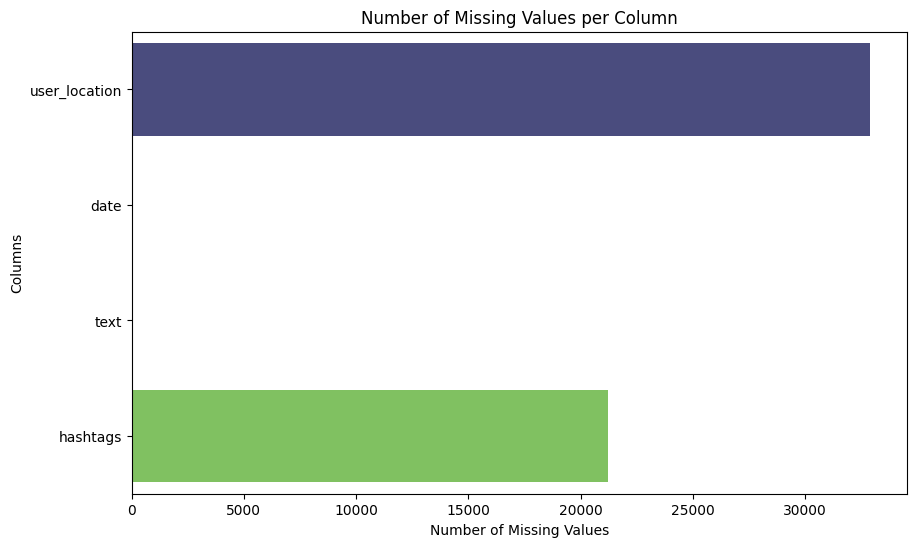

In [11]:
missing_values_per_column = df.isnull().sum()

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values_per_column.values, y=missing_values_per_column.index, palette='viridis')
plt.xlabel('Number of Missing Values')
plt.ylabel('Columns')
plt.title('Number of Missing Values per Column')
plt.show()

###After Handling

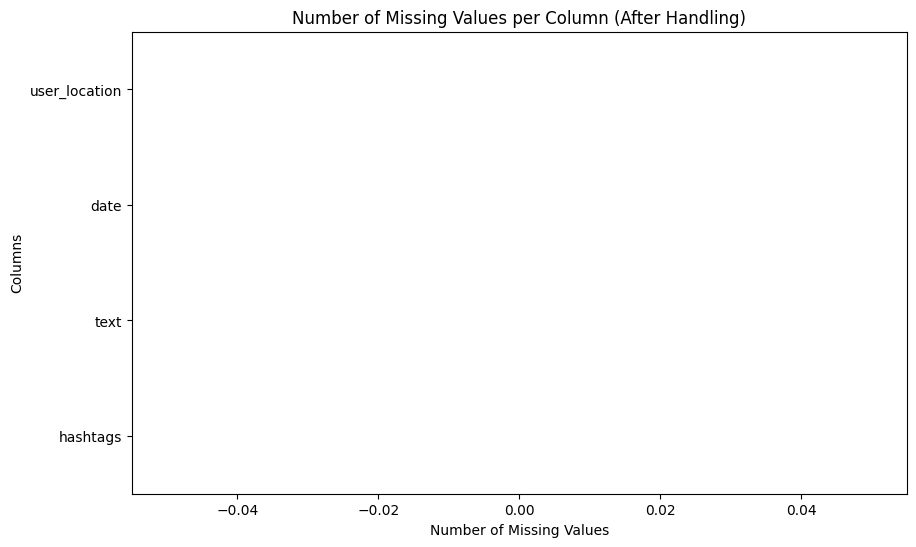

In [12]:
# Fill missing values with empty strings as missing values are found in columns of string type
string_columns = df.select_dtypes(include=['object']).columns
df[string_columns] = df[string_columns].fillna('')

missing_values_per_column_after_handling = df.isnull().sum()

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values_per_column_after_handling.values, y=missing_values_per_column_after_handling.index, palette='viridis')
plt.xlabel('Number of Missing Values')
plt.ylabel('Columns')
plt.title('Number of Missing Values per Column (After Handling)')
plt.show()

#Visualisition

##Top User Locations for Metaverse Tweets

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127468 (\N{REGIONAL INDICATOR SYMBOL LETTER G}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127463 (\N{REGIONAL INDICATOR SYMBOL LETTER B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


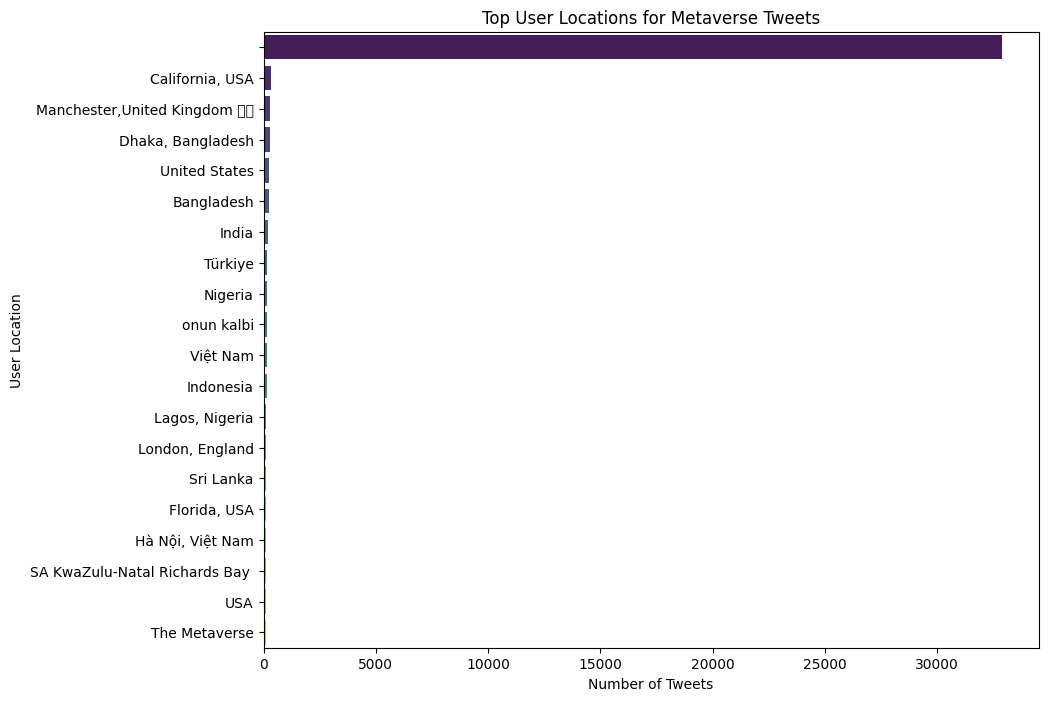

In [13]:
# Excludeing rows with 'Metaverse' as the user location cause its not a real geographic location
df_filtered = df[df['user_location'] != 'Metaverse']

top_user_locations = df_filtered['user_location'].value_counts().head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_user_locations.values, y=top_user_locations.index, palette='viridis')
plt.xlabel('Number of Tweets')
plt.ylabel('User Location')
plt.title('Top User Locations for Metaverse Tweets')
plt.show()

##Geographical Heatmap of Tweet Distribution

In [14]:
# To load 'naturalearth_lowres' a world map dataset  from Geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

unique_locations = df_filtered['user_location'].str.split(',').str[0].str.strip().unique()

# Mapping the locations
location_mapping = {
    'On The Block': 'Other',
    'ghana': 'Ghana',
    'Kansas City': 'Kansas City',
    'Ульяновск': 'Ulyanovsk, Russia',
    'Kuningan': 'Kuningan, Indonesia',
    'Queens': 'Queens, New York, United States',
    '$SHIBA$': 'Other',
    'Kota Padang': 'Kota Padang, Indonesia',
    'Alaşehir': 'Alaşehir, Turkey',
    'Oyo State': 'Oyo State, Nigeria',
    '日本最大級\u3000クリプト\u3000kudasai JP👉': 'Japan',
    '101 crypto st': 'Other',
    'Brave New World': 'Other',
    'The Void': 'Other',
    'Ayobo': 'Ayobo, Nigeria',
    'Santa Monica': 'Santa Monica, California, United States',
    'Airdrop and Bounty': 'Other',
    'In the metaverse or something': 'Other',
    'Moneymore': 'Moneymore, United Kingdom',
    'Lugano': 'Lugano, Switzerland',
    'Asaba': 'Asaba, Nigeria',
    '🇵🇭 gcash 09457299751': 'Philippines',
    'Nigeria🤔': 'Nigeria',
    'Doncaster': 'Doncaster, United Kingdom',
    'Central java': 'Central Java, Indonesia',
    'Newton': 'Newton, United States',
    'Heidelberg': 'Heidelberg, Germany',
    'Koceli - İzmit': 'Koceli - İzmit, Turkey',
    'Crypto Moon': 'Other',
    'Одеса': 'Odesa, Ukraine',
    'Büyükçekmece': 'Büyükçekmece, Turkey',
    'Binance Smart Chain Metaverse': 'Other',
    'onun kalbi': 'Other',
    'Latvia 🇱🇻': 'Latvia',
    'Cape Town': 'Cape Town, South Africa',
    'Yenibosna': 'Yenibosna, Turkey',
    'Belém': 'Belém, Brazil',
    'Nevşehir': 'Nevşehir, Turkey',
    'Tulsa': 'Tulsa, United States',
    'AKURE': 'Akure, Nigeria',
    'Cyprus & UK': 'Other',
    'Planet Namek': 'Other',
    'İstanbul / Avcılar': 'Istanbul, Turkey',
    'Oshiverse': 'Other',
    'çeşme-izmir': 'Çeşme, Izmir, Turkey',
    'Ayvacık': 'Ayvacık, Turkey',
    'Sadrazamın BEDENİNDE': 'Other',
    'Earth~': 'Other',
    'Cat Topia': 'Other',
    'Croatia': 'Croatia',
    'İzmir / İstanbul': 'Izmir, Turkey',
    'Rahim ibu': 'Other',
    'Thoughts': 'Other',
    'Sialkot': 'Sialkot, Pakistan',
    'Şişli': 'Şişli, Turkey',
    'Jalpaiguri': 'Jalpaiguri, India',
    'bigwin¹⁷': 'Other',
    'Crypto Moon Land': 'Other',
    'OMNWXJKQ9GY': 'Other',
    'depok - indonesia': 'Depok, Indonesia',
    'Sandusky': 'Sandusky, United States',
    'TASKOPRU': 'Other',
    'Ukraine 🇺🇦': 'Ukraine',
    'Glendale': 'Glendale, United States',
    'Califonia': 'California, United States',
    'Planet Saitama': 'Other',
    'Mexico': 'Mexico',
    'US Texas': 'Texas, United States',
    'Stavische': 'Other',
    'Transcending All Boundaries': 'Other',
    'Martinsburg': 'Martinsburg, United States',
    'Kailua': 'Kailua, United States',
    'Ağrı Merkez': 'Ağrı Merkez, Turkey',
    'Monaco': 'Monaco',
    'Rockville': 'Rockville, United States',
    'Philly/County/🇯🇲': 'Other',
    'Guadalajara': 'Guadalajara, Mexico',
    'Samsun': 'Samsun, Turkey',
    'Shiba Family NFT': 'Other',
    'Kars': 'Kars, Turkey',
    'Edo': 'Edo, Nigeria',
    'www.gtaland.io': 'Other',
    'Crypto Ecosystem': 'Other',
    'Rio Preto': 'Rio Preto, Brazil',
    'Barquisimeto': 'Barquisimeto, Venezuela',
    'Sirajganj': 'Sirajganj, Bangladesh',
    'Mechelen': 'Mechelen, Belgium',
    'Bholahat': 'Bholahat, Bangladesh',
    'European Union 🇪🇺': 'Other',
    'Ife': 'Ife, Nigeria',
    'Peninsula of Freedom 🌴 WPB FL': 'Other',
    'Fındıklı ✌🏻': 'Fındıklı, Turkey',
    'osun-state': 'Osun State, Nigeria',
    'katsina': 'Katsina, Nigeria',
    'Puerto ordaz': 'Puerto Ordaz, Venezuela',
    'Jakarta Pusat': 'Jakarta Pusat, Indonesia',
    'Present': 'Other',
    'USA & Europe Servers': 'Other',
    'Dasmarinas Cavite 🇵🇭': 'Dasmariñas, Cavite, Philippines',
    'The goat herd': 'Other',
    'Not there yet': 'Other',
    "Tom Brady's Neighbour": 'Other',
    '14/07/2013 AF': 'Other',
    'Clunge Dungeon': 'Other',
    'Dorset': 'Dorset, United Kingdom',
    'SORATOPIA': 'Other',
    'The Union': 'Other',
    'Negril': 'Negril, Jamaica',
    'ÜT: 47.784528': 'Other',
    'Kingdom of Caring': 'Other',
    'Erzincan Merkez': 'Erzincan Merkez, Turkey',
    'Αττική': 'Attica, Greece',
    'Lublin': 'Lublin, Poland',
    'TBD': 'Other',
    'Aydın Kuşadası': 'Aydın Kuşadası, Turkey',
    'New Orleans': 'New Orleans, United States',
    'dm for business': 'Other',
    'Ooty - cbe - Tirupur - Ooty': 'Other',
    '@everywhere': 'Other',
    'Hotel Cortez': 'Other',
    'my room': 'Other',
    'Tugu Mulyo': 'Other',
    'Limbo': 'Other',
    'NFTland': 'Other',
    'Walk of fame': 'Other',
    'Glocal // SoFL': 'Other',
    'lightning.network': 'Other',
    'Iraq': 'Iraq',
    'Sandaga - Paris - Los Angeles': 'Other',
    'Watertown': 'Watertown, United States',
    'Maracaibo - Venezuela': 'Maracaibo, Venezuela',
    'world wide': 'Other',
    'Orange': 'Orange, United States',
    'Santa Inu': 'Other',
    '🔥Hot Land😏': 'Other',
    '✶ ✶ ✶ ✶': 'Other',
    'protonia': 'Other',
    'Rbl': 'Other',
    'on a rocket to the moon': 'Other',
    'Napoli': 'Naples, Italy',
    '$sauce': 'Other',
    'Genesis District | Lunacia': 'Other',
    'Brooklyn': 'Brooklyn, New York, United States',
    'Cirebon': 'Cirebon, Indonesia',
    'Zonguldak': 'Zonguldak, Turkey',
    'Everywhere and No Where': 'Other',
    'degen millionaires golf course': 'Other',
    'Boston/Los Angeles': 'Other',
    '🌍 🌎 🌏 Discord: MyetaM#3187': 'Other',
    'GDL - Mexico': 'Guadalajara, Mexico',
    '💰DM for NFT Promos!': 'Other',
    'ďünya': 'Other',
    'INQUIRY: dappcentre@gmail.com': 'Other',
    'Wales': 'Wales, United Kingdom',
    'Minocqua': 'Minocqua, United States',
    'Spain & Latam 🌍': 'Other',
    'Indianapolis': 'Indianapolis, United States',
    # Add more locations here...
    'Indonesia 🇮🇩🇮🇩🇮🇩': 'Indonesia',
    'cyberpunk future': 'Other',
    'Planet Pluto': 'Other',
    'BHARAT🚩': 'Other',
    'Dausa': 'Dausa, India',
    'somewhere in the ocean': 'Other',
    'Gotham': 'Gotham City',
    'Ketapang': 'Ketapang, Indonesia',
    'NFTs': 'Other',
    'ogbomoso': 'Ogbomoso, Nigeria',
    '🇮🇩 | she/her': 'Indonesia',
    '熊本県熊本市': 'Kumamoto, Japan',
    'yemen-sanaa-11 street': 'Sanaa, Yemen',
    'Tiny dot called The Milky Way': 'Milky Way Galaxy',
    'jawa': 'Java, Indonesia',
    'Toledo City': 'Toledo City, Philippines',
    'murarai': 'Murarai, India',
    'Şehitkamil': 'Şehitkamil, Turkey',
    'Mongolia': 'Mongolia',
    'In the future': 'Other',
    'Remote': 'Remote Location',
    'TR': 'Turkey',
    'United states': 'United States',
    'Ullapara': 'Ullapara, Bangladesh',
    'close to the moon': 'Other',
    'Zaria': 'Zaria, Nigeria',
    '🇮🇳': 'India',
    'New Brunswick': 'New Brunswick, Canada',
    'Camaya': 'Camaya, Philippines',
    'Киев': 'Kyiv, Ukraine',
    'Bageshwar': 'Bageshwar, India',
    'Sebelah Rumah Messi': 'Near Messi\'s House',
    'Oulu': 'Oulu, Finland',
    'us king': 'Other',
    'Sick World': 'Other',
    'Nunya': 'Nunya Business',
    'Narayangan': 'Narayanganj, Bangladesh',
    'Hell! Literally!': 'Hell',
    'pabna Rajshahi Bangladesh': 'Pabna, Bangladesh',
    'Calgary': 'Calgary, Canada',
    '#StayHome | Manchester': 'Manchester, United Kingdom',
    'Daltonganj': 'Daltonganj, India',
    'THE CARVALHO ESTATE': 'Carvalho Estate',
    'Ngawi jawa timur': 'Ngawi, Indonesia',
    'Mumbai 🇮🇳': 'Mumbai, India',
    'Changwat Phuket': 'Phuket, Thailand',
    'whale fall army space warship': 'Other',
    'Hongdae': 'Hongdae, South Korea',
    '🇹🇼🇹🇼🇹🇼🇹🇼🇹🇼🇹🇼🇹🇼🇹🇼🇹🇼': 'Taiwan',
}

#Removing all Other Locations as they are unexisting and madeup
location_mapping = {k: v for k, v in location_mapping.items() if v != 'Other'}

<ipython-input-14-60c48d83aa23>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


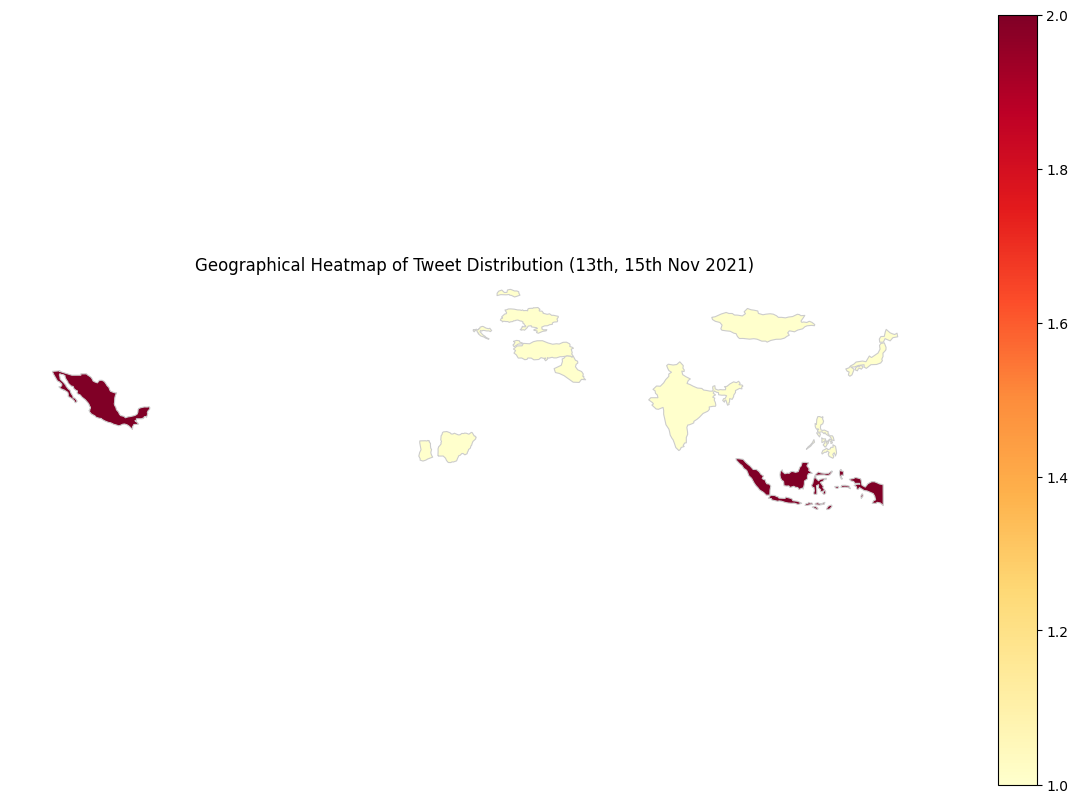

In [15]:
from collections import Counter
user_locations = df_filtered['user_location'].str.strip()

# Preprocess user locations to extract country or state information
user_locations = user_locations.str.split(',').str[0].str.strip()

# Using Counter to count tweets from each country/region
location_mapping = Counter(
    [location_mapping.get(location, 'Other') for location in user_locations]
)

# Creating a DataFrame from the location counts
location_df = pd.DataFrame.from_dict(location_mapping, orient='index', columns=['Tweet Count'])

# Merging with the world map dataset based on country/region names
world['Country'] = world['name']
merged = world.set_index('Country').join(location_df)

# Creating a heatmap
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.plot(column='Tweet Count', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Geographical Heatmap of Tweet Distribution (13th, 15th Nov 2021)')
ax.axis('off')
plt.show()


##Identifying Popular Hashtags and Mentions in Tweets

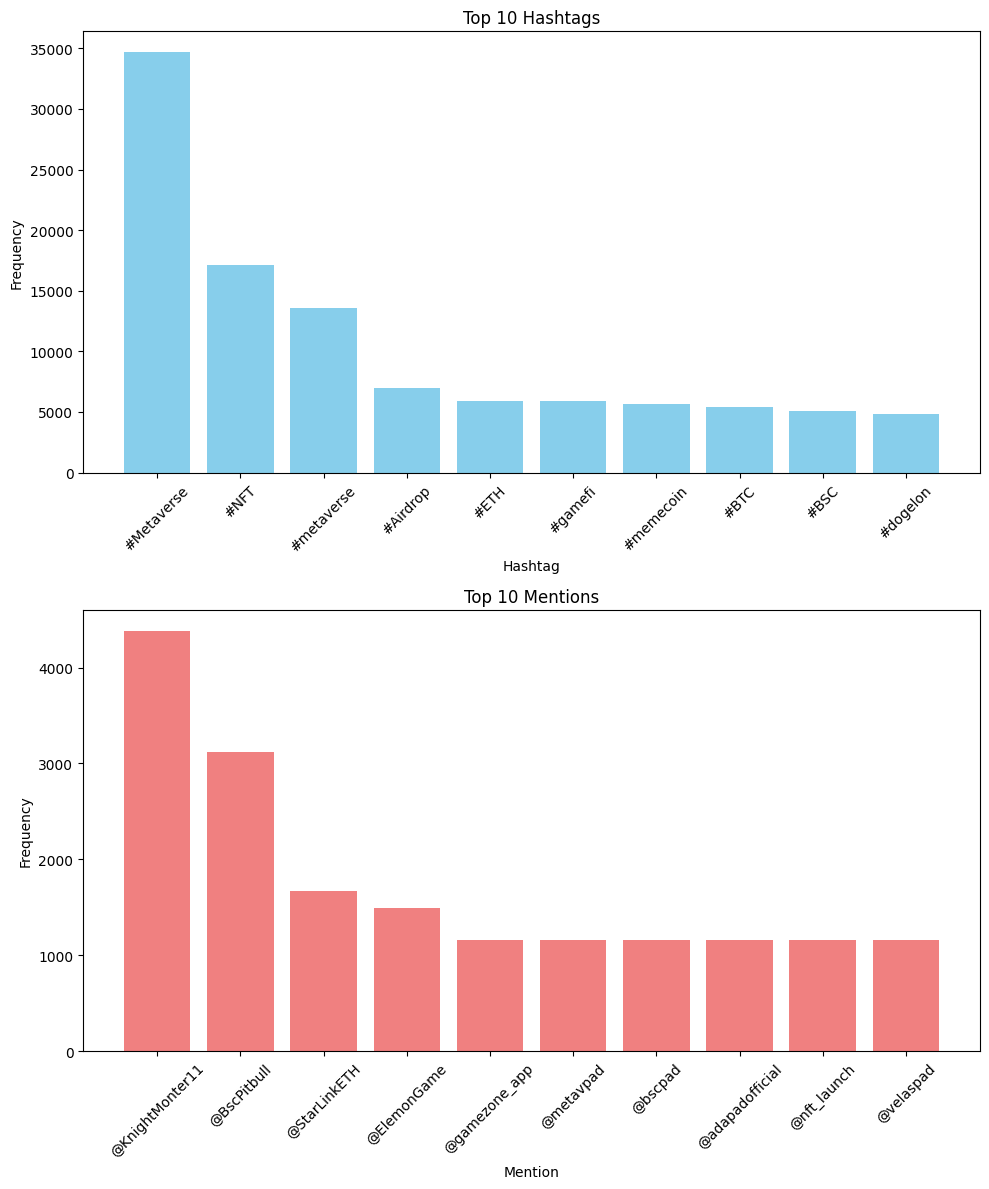

In [16]:
def extract_hashtags_and_mentions(text):
    hashtags = re.findall(r'#\w+', text)
    mentions = re.findall(r'@\w+', text)
    return hashtags, mentions

df['hashtags'], df['mentions'] = zip(*df['text'].apply(extract_hashtags_and_mentions))

# Flattening the lists of hashtags and mentions
all_hashtags = [tag for sublist in df['hashtags'] for tag in sublist]
all_mentions = [mention for sublist in df['mentions'] for mention in sublist]

# Counting the frequency
hashtag_counts = Counter(all_hashtags)
mention_counts = Counter(all_mentions)

top_hashtags = hashtag_counts.most_common(10)
top_mentions = mention_counts.most_common(10)

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plotting top hashtags
axes[0].bar([tag[0] for tag in top_hashtags], [tag[1] for tag in top_hashtags], color='skyblue')
axes[0].set_title('Top 10 Hashtags')
axes[0].set_xlabel('Hashtag')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Plotting top mentions
axes[1].bar([mention[0] for mention in top_mentions], [mention[1] for mention in top_mentions], color='lightcoral')
axes[1].set_title('Top 10 Mentions')
axes[1].set_xlabel('Mention')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

#Text Analysis: Visualize Word Frequencies

In [17]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40,
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

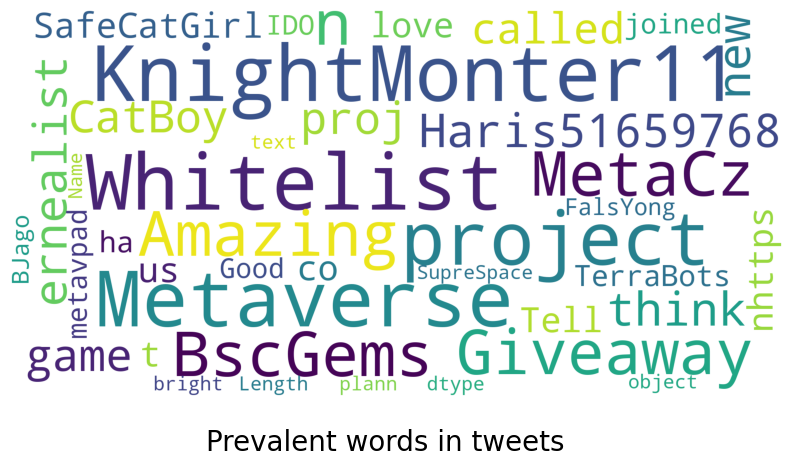

In [18]:
show_wordcloud(df['text'], title = 'Prevalent words in tweets')

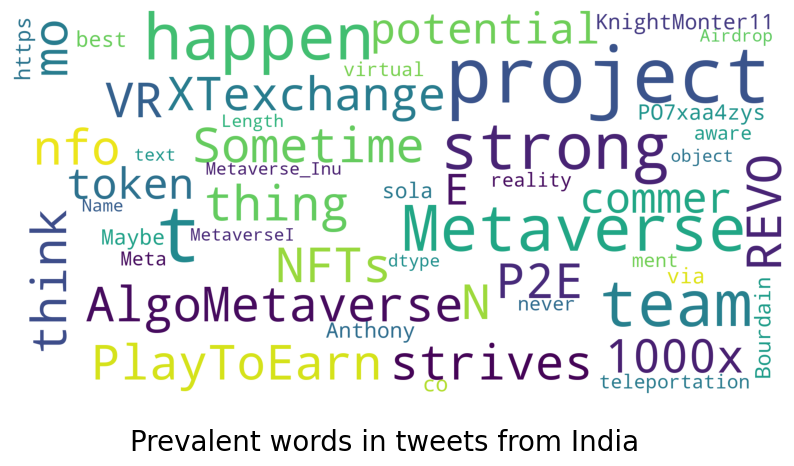

In [19]:
india_df = df.loc[df.user_location=="India"]
show_wordcloud(india_df['text'], title = 'Prevalent words in tweets from India')


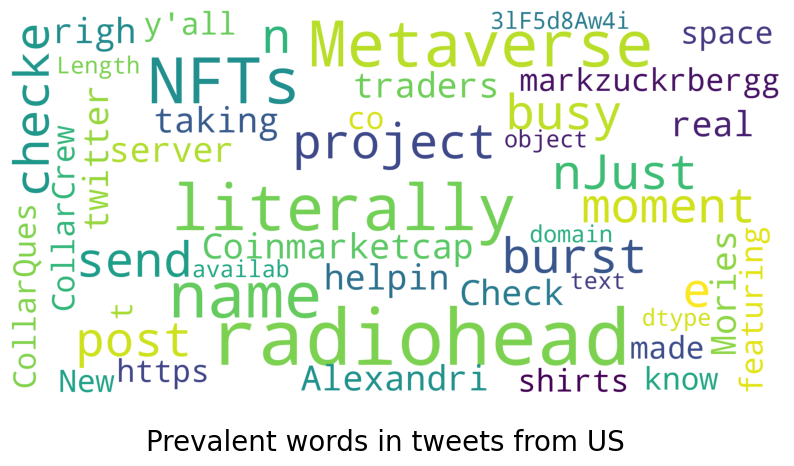

In [20]:
us_df = df.loc[df.user_location=="United States"]
show_wordcloud(us_df['text'], title = 'Prevalent words in tweets from US')

#Using Sentiment Analyzers

##Sentiment Analysis with AFINN

In [21]:
afinn_analyzer = Afinn()

def analyze_sentiment_afinn(text):
    score = afinn_analyzer.score(text)
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_afinn'] = df['text'].apply(analyze_sentiment_afinn)

##Sentiment Analysis with VADER

In [22]:
vader_analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(text):
    sentiment = vader_analyzer.polarity_scores(text)
    if sentiment['compound'] >= 0.05:
        return 'Positive'
    elif sentiment['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_vader'] = df['text'].apply(analyze_sentiment_vader)

##Sentiment Analysis with TextBlob

In [23]:
def analyze_sentiment_textblob(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_textblob'] = df['text'].apply(analyze_sentiment_textblob)

##Findings

##Analyzers Result

In [24]:
positive_percentage_afinn = (df['sentiment_afinn'] == 'Positive').mean() * 100
neutral_percentage_afinn = (df['sentiment_afinn'] == 'Neutral').mean() * 100
negative_percentage_afinn = (df['sentiment_afinn'] == 'Negative').mean() * 100

positive_percentage_vader = (df['sentiment_vader'] == 'Positive').mean() * 100
neutral_percentage_vader = (df['sentiment_vader'] == 'Neutral').mean() * 100
negative_percentage_vader = (df['sentiment_vader'] == 'Negative').mean() * 100

positive_percentage_textblob = (df['sentiment_textblob'] == 'Positive').mean() * 100
neutral_percentage_textblob = (df['sentiment_textblob'] == 'Neutral').mean() * 100
negative_percentage_textblob = (df['sentiment_textblob'] == 'Negative').mean() * 100

# Creating a DataFrame to store the percentages
sentiment_percentage_df = pd.DataFrame({
    'Afinn': [positive_percentage_afinn, neutral_percentage_afinn, negative_percentage_afinn],
    'Vader': [positive_percentage_vader, neutral_percentage_vader, negative_percentage_vader],
    'Textblob': [positive_percentage_textblob, neutral_percentage_textblob, negative_percentage_textblob]
}, index=['Positive (%)', 'Neutral (%)', 'Negative (%)'])

print(sentiment_percentage_df)

                  Afinn      Vader   Textblob
Positive (%)  58.190096  59.736457  60.857618
Neutral (%)   36.627289  34.800136  30.371648
Negative (%)   5.182615   5.463407   8.770733


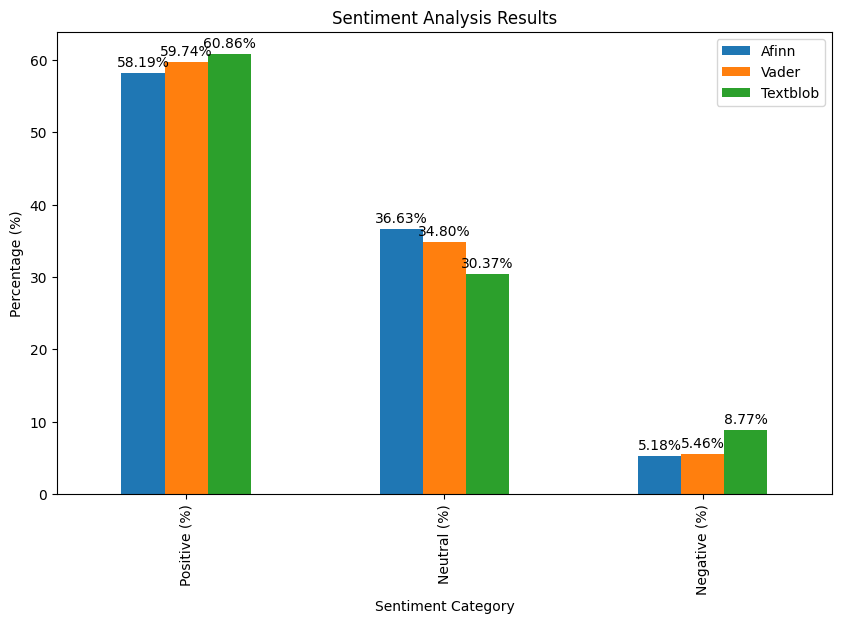

In [25]:
# Bar graph Visualization
ax = sentiment_percentage_df.plot(kind='bar', figsize=(10, 6))
plt.title('Sentiment Analysis Results')
plt.xlabel('Sentiment Category')
plt.ylabel('Percentage (%)')

# To add values on top of each bar with a slight offset
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height() + 0.5), ha='center', va='bottom')

plt.show()

#Lemmatization and ML models

##Preprocess text and Lemmatization using Vader sentiment scores

In [26]:
lemmatizer = WordNetLemmatizer()

def preprocess_and_lemmatize_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = text.lower()

        tokens = text.split()

        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

        lemmatized_text = ' '.join(lemmatized_tokens)

        return lemmatized_text
    else:
        return ''

df['processed_text'] = df['text'].apply(preprocess_and_lemmatize_text)

vader_analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment_score(text):
    sentiment_scores = vader_analyzer.polarity_scores(text)
    return sentiment_scores['compound']

df['sentiment_vader'] = df['processed_text'].apply(get_vader_sentiment_score)

def categorize_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['sentiment_vader'].apply(categorize_sentiment)

positive_samples = df[df['sentiment_label'] == 'positive']
neutral_samples = df[df['sentiment_label'] == 'neutral']
negative_samples = df[df['sentiment_label'] == 'negative']

min_samples = min(len(positive_samples), len(neutral_samples), len(negative_samples))

# Resampling each class so that all have the same number of sample
positive_samples_balanced = resample(positive_samples, replace=False, n_samples=min_samples, random_state=42)
neutral_samples_balanced = resample(neutral_samples, replace=False, n_samples=min_samples, random_state=42)
negative_samples_balanced = resample(negative_samples, replace=False, n_samples=min_samples, random_state=42)

df_balanced = pd.concat([positive_samples_balanced, neutral_samples_balanced, negative_samples_balanced])

In [27]:
X = df_balanced['processed_text']  # Features
y = df_balanced['sentiment_label']  # Target variable

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

##Logistic Regression

In [28]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)

cv_scores = cross_val_score(lr_model, X_train_tfidf, y_train_encoded, cv=5)

lr_model.fit(X_train_tfidf, y_train_encoded)

y_pred_lr = lr_model.predict(X_test_tfidf)

accuracy_lr = accuracy_score(y_test_encoded, y_pred_lr)

class_report_lr = classification_report(y_test_encoded, y_pred_lr)

print("Logistic Regression with Cross-Validation:")
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')
print(f'Accuracy on Test Set: {accuracy_lr}')
print('Classification Report:\n', class_report_lr)


Logistic Regression with Cross-Validation:
Cross-Validation Accuracy Scores: [0.83139535 0.8127907  0.84069767 0.81860465 0.80813953]
Mean CV Accuracy: 0.8223255813953487
Accuracy on Test Set: 0.8308550185873605
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.90      0.82       352
           1       0.84      0.78      0.81       338
           2       0.93      0.81      0.86       386

    accuracy                           0.83      1076
   macro avg       0.84      0.83      0.83      1076
weighted avg       0.84      0.83      0.83      1076



##Random Forest

In [29]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

cv_scores_rf = cross_val_score(rf_model, X_train_tfidf, y_train_encoded, cv=5)

rf_model.fit(X_train_tfidf, y_train_encoded)

y_pred_rf = rf_model.predict(X_test_tfidf)

accuracy_rf = accuracy_score(y_test_encoded, y_pred_rf)

classification_rep_rf = classification_report(y_test_encoded, y_pred_rf)

print("Random Forest with Cross-Validation:")
print(f'Cross-Validation Accuracy Scores: {cv_scores_rf}')
print(f'Mean CV Accuracy: {cv_scores_rf.mean()}')
print(f'Accuracy on Test Set: {accuracy_rf}')
print('Classification Report:\n', classification_rep_rf)


Random Forest with Cross-Validation:
Cross-Validation Accuracy Scores: [0.81395349 0.81860465 0.83023256 0.82790698 0.79651163]
Mean CV Accuracy: 0.8174418604651162
Accuracy on Test Set: 0.837360594795539
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83       352
           1       0.83      0.84      0.84       338
           2       0.93      0.77      0.84       386

    accuracy                           0.84      1076
   macro avg       0.84      0.84      0.84      1076
weighted avg       0.85      0.84      0.84      1076



##SVM (kernel = linear)

In [30]:
svm_model = SVC(kernel='linear', C=1, random_state=42)

cv_scores_svm = cross_val_score(svm_model, X_train_tfidf, y_train_encoded, cv=5)

svm_model.fit(X_train_tfidf, y_train_encoded)

y_pred_svm = svm_model.predict(X_test_tfidf)

accuracy_svm = accuracy_score(y_test_encoded, y_pred_svm)

classification_rep_svm = classification_report(y_test_encoded, y_pred_svm)

print("Support Vector Machine (SVM) with Cross-Validation:")
print(f'Cross-Validation Accuracy Scores: {cv_scores_svm}')
print(f'Mean CV Accuracy: {cv_scores_svm.mean()}')
print(f'Accuracy on Test Set: {accuracy_svm}')
print('Classification Report:\n', classification_rep_svm)


Support Vector Machine (SVM) with Cross-Validation:
Cross-Validation Accuracy Scores: [0.82906977 0.83255814 0.83953488 0.81860465 0.81511628]
Mean CV Accuracy: 0.8269767441860466
Accuracy on Test Set: 0.8578066914498141
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       352
           1       0.87      0.83      0.85       338
           2       0.92      0.84      0.88       386

    accuracy                           0.86      1076
   macro avg       0.86      0.86      0.86      1076
weighted avg       0.86      0.86      0.86      1076



###SVM with RBF kernel

In [31]:
svm_rbf_model = SVC(kernel='rbf', C=1, random_state=42)

cv_scores_svm_rbf = cross_val_score(svm_rbf_model, X_train_tfidf, y_train_encoded, cv=5)

svm_rbf_model.fit(X_train_tfidf, y_train_encoded)

y_pred_svm_rbf = svm_rbf_model.predict(X_test_tfidf)

accuracy_svm_rbf = accuracy_score(y_test_encoded, y_pred_svm_rbf)

classification_rep_svm_rbf = classification_report(y_test_encoded, y_pred_svm_rbf)

print("Support Vector Machine (SVM) with RBF Kernel and Cross-Validation:")
print(f'Cross-Validation Accuracy Scores: {cv_scores_svm_rbf}')
print(f'Mean CV Accuracy: {cv_scores_svm_rbf.mean()}')
print(f'Accuracy on Test Set: {accuracy_svm_rbf}')
print('Classification Report:\n', classification_rep_svm_rbf)


Support Vector Machine (SVM) with RBF Kernel and Cross-Validation:
Cross-Validation Accuracy Scores: [0.81162791 0.8127907  0.82674419 0.80813953 0.78953488]
Mean CV Accuracy: 0.8097674418604651
Accuracy on Test Set: 0.8262081784386617
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.93      0.81       352
           1       0.88      0.75      0.81       338
           2       0.95      0.80      0.87       386

    accuracy                           0.83      1076
   macro avg       0.84      0.83      0.83      1076
weighted avg       0.85      0.83      0.83      1076



##Decision Tree

In [32]:
dt_model = DecisionTreeClassifier(random_state=42)

cv_scores_dt = cross_val_score(dt_model, X_train_tfidf, y_train_encoded, cv=5)

dt_model.fit(X_train_tfidf, y_train_encoded)

y_pred_dt = dt_model.predict(X_test_tfidf)


accuracy_dt = accuracy_score(y_test_encoded, y_pred_dt)

classification_rep_dt = classification_report(y_test_encoded, y_pred_dt)

print("Decision Tree with Cross-Validation:")
print(f'Cross-Validation Accuracy Scores: {cv_scores_dt}')
print(f'Mean CV Accuracy: {cv_scores_dt.mean()}')
print(f'Accuracy on Test Set: {accuracy_dt}')
print('Classification Report:\n', classification_rep_dt)


Decision Tree with Cross-Validation:
Cross-Validation Accuracy Scores: [0.77093023 0.75581395 0.77209302 0.77674419 0.72906977]
Mean CV Accuracy: 0.7609302325581394
Accuracy on Test Set: 0.7388475836431226
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.66      0.70       352
           1       0.70      0.83      0.76       338
           2       0.78      0.73      0.75       386

    accuracy                           0.74      1076
   macro avg       0.74      0.74      0.74      1076
weighted avg       0.74      0.74      0.74      1076



##Gradient Boosting/ XGBoost

In [33]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_tfidf, y_train_encoded)

y_pred_gb = xgb_model.predict(X_test_tfidf)
accuracy_gb = accuracy_score(y_test_encoded, y_pred_gb)
print(f"XGBoost Accuracy: {accuracy_gb:.2f}")

class_report = classification_report(y_test_encoded, y_pred_gb)
print("\nClassification Report (XGBoost):\n", class_report)

XGBoost Accuracy: 0.85

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.82      0.86      0.84       352
           1       0.83      0.90      0.86       338
           2       0.91      0.81      0.86       386

    accuracy                           0.85      1076
   macro avg       0.85      0.86      0.85      1076
weighted avg       0.86      0.85      0.85      1076



##LightGBM

In [34]:
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train_tfidf, y_train_encoded)

y_pred_lightbgm = lgbm_model.predict(X_test_tfidf)
accuracy_lightgbm = accuracy_score(y_test_encoded, y_pred_lightbgm)
print(f"LightGBM Accuracy: {accuracy_lightgbm:.2f}")

class_report = classification_report(y_test_encoded, y_pred_lightbgm)
print("\nClassification Report (LightGBM):\n", class_report)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17918
[LightGBM] [Info] Number of data points in the train set: 4300, number of used features: 665
[LightGBM] [Info] Start training from score -1.093972
[LightGBM] [Info] Start training from score -1.084297
[LightGBM] [Info] Start training from score -1.117866
LightGBM Accuracy: 0.86

Classification Report (LightGBM):
               precision    recall  f1-score   support

           0       0.83      0.84      0.84       352
           1       0.83      0.91      0.87       338
           2       0.92      0.82      0.87       386

    accuracy                           0.86      1076
   macro avg       0.86      0.86      0.86      1076
weighted avg       0.86      0.86      0.86      1076



##CatBoost

In [35]:
catboost_model = CatBoostClassifier(random_state=42)
catboost_model.fit(X_train_tfidf, y_train_encoded)

y_pred_catboost = catboost_model.predict(X_test_tfidf)
accuracy_catboost = accuracy_score(y_test_encoded, y_pred_catboost)
print(f"CatBoost Accuracy: {accuracy_catboost:.2f}")

class_report = classification_report(y_test_encoded, y_pred_catboost)
print("\nClassification Report (CatBoost):\n", class_report)

Learning rate set to 0.085237
0:	learn: 1.0544885	total: 366ms	remaining: 6m 5s
1:	learn: 1.0235441	total: 586ms	remaining: 4m 52s
2:	learn: 0.9975179	total: 801ms	remaining: 4m 26s
3:	learn: 0.9749814	total: 1s	remaining: 4m 10s
4:	learn: 0.9555383	total: 1.25s	remaining: 4m 8s
5:	learn: 0.9350642	total: 1.46s	remaining: 4m 2s
6:	learn: 0.9196507	total: 1.66s	remaining: 3m 55s
7:	learn: 0.9054235	total: 1.87s	remaining: 3m 52s
8:	learn: 0.8913865	total: 2.08s	remaining: 3m 48s
9:	learn: 0.8794183	total: 2.31s	remaining: 3m 48s
10:	learn: 0.8670224	total: 2.52s	remaining: 3m 46s
11:	learn: 0.8573827	total: 2.74s	remaining: 3m 45s
12:	learn: 0.8483907	total: 2.94s	remaining: 3m 43s
13:	learn: 0.8380259	total: 3.35s	remaining: 3m 56s
14:	learn: 0.8306603	total: 3.66s	remaining: 4m
15:	learn: 0.8222154	total: 3.96s	remaining: 4m 3s
16:	learn: 0.8140429	total: 4.31s	remaining: 4m 9s
17:	learn: 0.8055232	total: 4.59s	remaining: 4m 10s
18:	learn: 0.7973502	total: 4.89s	remaining: 4m 12s
19:	

##Multinomial Naive Bayes classifier

In [36]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train_encoded)
y_pred_nb = nb_model.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test_encoded, y_pred_nb)

class_report = classification_report(y_test_encoded, y_pred_nb)
print("\nClassification Report (MultinomialNB):\n", class_report)


Classification Report (MultinomialNB):
               precision    recall  f1-score   support

           0       0.69      0.93      0.79       352
           1       0.88      0.67      0.76       338
           2       0.89      0.79      0.84       386

    accuracy                           0.80      1076
   macro avg       0.82      0.80      0.80      1076
weighted avg       0.82      0.80      0.80      1076



##Multi-layer Perceptron

In [37]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(random_state=42)
mlp_model.fit(X_train_tfidf, y_train_encoded)
y_pred_mlp = mlp_model.predict(X_test_tfidf)
accuracy_mlp = accuracy_score(y_test_encoded, y_pred_mlp)

class_report = classification_report(y_test_encoded, y_pred_mlp)
print("\nClassification Report (MultinomialNB):\n", class_report)


Classification Report (MultinomialNB):
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       352
           1       0.84      0.81      0.83       338
           2       0.89      0.85      0.87       386

    accuracy                           0.84      1076
   macro avg       0.84      0.84      0.84      1076
weighted avg       0.85      0.84      0.84      1076



##Findings

In [38]:
model_names = ["Logistic Regression", "Random Forest", "SVM", "SVM RBF", "Decision Tree", "Gradient Boosting", "LightGBM", "CatBoost", "MLP", "MNB"]

accuracy_scores = [accuracy_lr, accuracy_rf, accuracy_svm, accuracy_svm_rbf, accuracy_dt, accuracy_gb, accuracy_lightgbm, accuracy_catboost, accuracy_mlp, accuracy_nb]

results_df = pd.DataFrame({'Model': model_names, 'Accuracy': accuracy_scores})

results_df

,Model,Accuracy
0,Logistic Regression,0.830855
1,Random Forest,0.837361
2,SVM,0.857807
3,SVM RBF,0.826208
4,Decision Tree,0.738848
5,Gradient Boosting,0.853160
6,LightGBM,0.857807
7,CatBoost,0.830855
8,MLP,0.842937
9,MNB,0.798327


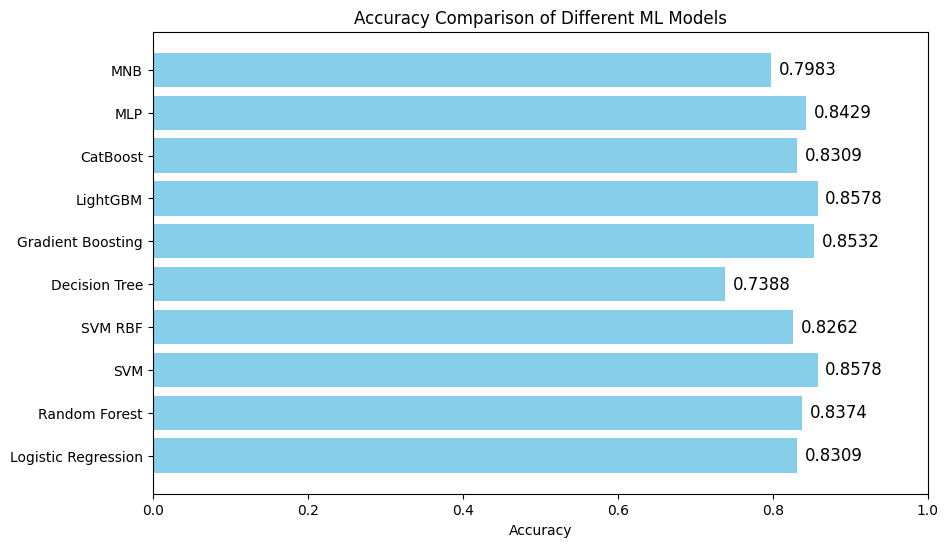

In [39]:
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['Accuracy'], color='skyblue')
plt.xlabel('Accuracy')
plt.title('Accuracy Comparison of Different ML Models')
plt.xlim(0, 1)

for i, v in enumerate(accuracy_scores):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=12, color='black')

plt.show()